# Twitter Sentiment Analysis using BERT Notebook 5.

In [ ]:
# import libraries

# library to interacte with file and time operations
import os
import time
import warnings
warnings.filterwarnings('ignore')

# library to work with regualar expressions
import re

# basic library
import pandas as pd
import numpy as np

# visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm
from tqdm import tnrange

# NLP libraries with nltk
from nltk.tokenize import WhitespaceTokenizer

# Deep learning libraries using PyTorch
import torch

# Deep learning libraries using Hugging Face
import transformers
from transformers import BertTokenizer

In [ ]:
# new library import



In [ ]:
!cp "/content/drive/MyDrive/Twitter_Sentiment_Analysis/training_processed_data.csv" "."


## Loading the data

In [ ]:
dataset = pd.read_csv("/content/training_processed_data.csv")
dataset.sample(5)

,target,text
615665,0,did pakistan enough win sure sa need run rate ...
1570074,1,watching soup mary murphy still crack
1330414,1,i give crack right i leave
867776,1,laying watching sun come
1484332,1,cuz karina shes like im jsut chillin oh boyf f...


In [ ]:
# check for null values
dataset.isnull().sum()

,0
target,0
text,27373


In [ ]:
# removing null values from the dataset
dataset.dropna(how = 'any', axis = 0, inplace = True)
dataset.isnull().sum()

,0
target,0
text,0


In [ ]:
dataset.info(memory_usage = 'deep')

<class 'pandas.core.frame.DataFrame'>
Index: 1572627 entries, 0 to 1599999
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1572627 non-null  int64 
 1   text    1572627 non-null  object
dtypes: int64(1), object(1)
memory usage: 160.2 MB


In [ ]:
dataset['target'].unique()

array([0, 1])

## Setting GPU for training

In [ ]:
# import library
import torch

In [ ]:
# set GPU for training if available
if torch.cuda.is_available():
  device = torch.device("cuda")
  print(f'There are {torch.cuda.device_count()} GPUs available.')
  print(f"Device select for training : {torch.cuda.get_device_name(0)}")

else:
  device = torch.device('cpu')
  print("No GPU available, using the CPU instead.")


No GPU available, using the CPU instead.


## Fine-Tuning BERT

### 1. Install the Hugging Face library

The transformer library of Hugging Face contains Pytorch implementation of state of the art NLP models including BERT, GPT and pre-trained model weights.

In [ ]:
# install transformer from Hugging Face
!pip install transformers --quiet

### 2. Tokenization and input Foramtting

For our current dataset, we have already performed Text- preprocessing in Notebook-1 where we have removed username, html links and various other. Therfore we can proceed with direct tokenization or we can explore text preprocessing later on.

In [ ]:
"""
Perform Text processing on the complete dataset from Kaggle
"""

'\nPerform Text processing on the complete dataset from Kaggle\n'

### 2.1 BERT Tokenizer

To utilize a pre-trained BERT model, we need to use the tokenizer provided by the library for the following reasons:

1. The BERT model operates with a predefined and fixed vocabulary.
2. The BERT tokenizer follows a specific approach to processing out-of-vocabulary words.


Additionally, it is necessary to:
1. Add special tokens at the beginning and end of each sentence.
2. Pad and truncate all sentences to a fixed length.
3. Explicitly define padding tokens using the "attention mask."

The encode_plus method of BERT tokenizer will:
1. split our text into tokens
2. add the special [CLS] and [SEP] tokens
3. convert these tokens into indexes of the tokenizer vocabulary
4. Pad or truncate sentences to max length, and
5. Create attention mask.

In [ ]:
# import tokenizer from BERT
from transformers import BertTokenizer

# import WhitespaceTokenizer from nltk
from nltk.tokenize import WhitespaceTokenizer

In [ ]:
# Initialize the BertTokenizer
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case = True)

ws_tokenizer = WhitespaceTokenizer()

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

,count,mean,std,min,25%,50%,75%,90%,95%,98.5%,max
text,1572627.0,6.117865,3.492852,1.0,3.0,6.0,8.0,11.0,12.0,15.0,40.0


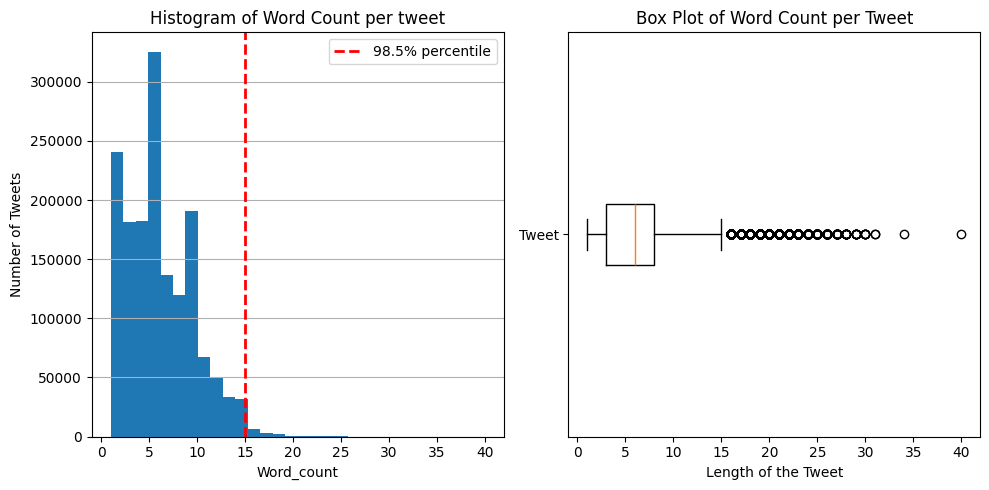

In [ ]:
# calculate the lenght of each tweet in dataset and store in len_tweet
len_tweet = dataset['text'].map(ws_tokenizer.tokenize).map(len)

# check descriptive statistic for length of the tweets
describe = pd.DataFrame(len_tweet.describe()).T
## calculating 90%, 95% and 98.5% percentile length of the tweets
percentile_90 = len_tweet.quantile(0.90)
percentile_95 = len_tweet.quantile(0.95)
percentile_985 = len_tweet.quantile(0.985)
# appending 90,95 and 98.5 percentile values to descirbe
describe['90%'] = percentile_90
describe['95%'] = percentile_95
describe['98.5%'] = percentile_985

# rearranging the columns orders
describe = describe[[col for col in describe.columns if col != 'max']+['max']]
display(describe)

# histogram of word count per tweets
plt.figure(figsize = (10,5))
plt.subplot(1,2,1)
plt.hist(len_tweet,bins = 30)
plt.title("Histogram of Word Count per tweet")
plt.axvline(percentile_985, color = 'red', linestyle = 'dashed', linewidth = 2,
            label = '98.5% percentile')
plt.xlabel("Word_count")
plt.ylabel("Number of Tweets")
plt.legend()
plt.grid(axis = 'y')

# Boxplot of word count per tweet
plt.subplot(1,2,2)
plt.boxplot(list(len_tweet), vert = False)
plt.title("Box Plot of Word Count per Tweet")
plt.xlabel("Length of the Tweet")
plt.yticks([1],["Tweet"])

# Adjust the layout
plt.tight_layout()
plt.show()

In [ ]:
# Define the maximum length for tweet
MAX_LENGTH = 15

In [ ]:
# function for tokenization
def preprocessing_for_bert(data):
  """Perfrom required preprocessing steps for pretrained BERT.
    @param    data(np.array):               Array of texts to be processed.
    @return   input_ids(torch.tensor):      Tenor of tokens ids to be fed to the BERT model.
    @return   attention_mask(torch.tensor): Tensor of indices specifying which tokens
                                            should be attended to by the model.
  """
  # empty list to store outputs
  input_ids = []
  attention_masks = []

  for sent in data:
    # encode_plus will:
    # 1. Tokenize the sentence
    # 2. Add the [CLS] and [SEP] token to the start and end
    # 3. Truncate/Pad sentence to max length
    # 4. Map tokens to their IDS
    # 5. create attention mask
    # 6. Return a dictionary of outputs
    encoded_sent = bert_tokenizer.encode_plus(
        text = sent,                        # Preprocessing sentences
        add_special_tokens = True,          # Add [CLS] and [SEP]
        max_length = MAX_LENGTH,       # Max Length to Truncate/Pad
        padding = 'max_length',           # Pad sentence to max_length
        # return_tensors = 'pt',            # Return Pytorch tensor
        return_attention_mask = True,# return attention mask
        truncation = True
        )

    # store the output to the list
    input_ids.append(encoded_sent.get('input_ids'))
    attention_masks.append(encoded_sent.get('attention_mask'))

  # convert to tensor
  input_ids = torch.tensor(input_ids)
  attention_masks = torch.tensor(attention_masks)


  return input_ids, attention_masks



In [ ]:
# Experiment
test_1 = dataset[0:10]
temp_inputs, train_masks= preprocessing_for_bert(test_1['text'])

In [ ]:
temp_inputs, train_masks

(tensor([[  101,  2017,  2323,  2050,  2288,  2585, 12385,  2353,  2154, 16837,
          15081,   102,     0,     0,     0],
         [  101,  6314, 10651,  9130,  3793,  2075,  2453,  5390,  2765,  2082,
           2651,   102,     0,     0,     0],
         [  101,  1045, 11529,  2094,  2116,  2051,  3266,  3828,  1996,  2717,
           2175,  5391,   102,     0,     0],
         [  101,  2878,  2303,  2514,  2009, 11714,  2066,  2543,   102,     0,
              0,     0,     0,     0,     0],
         [  101,  2022,  3270,  6455,  1045,  2156,   102,     0,     0,     0,
              0,     0,     0,     0,     0],
         [  101,  2878,  3626,   102,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0],
         [  101,  2342,  8549,   102,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0],
         [  101,  4931,  2146,  2051,  4542,  2978,  2978,  8840,  2140,  2986,
           4283,   102,     0,     0, 

### 2.3 Spliting data into Training and Testing data

In [ ]:
# import train_test_split from sklearn
from sklearn.model_selection import train_test_split

In [ ]:
# Ratio of split
TEST_RATIO = 0.1
VAL_RATIO  = 0.2

# Split the data into temp and test data
X_Temp_Train, X_Test, y_temp_train, y_test = train_test_split(dataset['text'],
                                                              dataset['target'],
                                                              test_size = TEST_RATIO,
                                                              random_state = 42,
                                                              )

# Split the X_Temp_Train and y_temp_train into Training and Validation set
X_Train, X_Val, y_train, y_val = train_test_split(X_Temp_Train,
                                                  y_temp_train,
                                                  test_size = VAL_RATIO,
                                                  random_state = 42)

In [ ]:
len(X_Train),len(X_Val), len(X_Test)

(1132291, 283073, 157263)

Let's tokenize the train and validation data

In [ ]:
# tokenizing train data
train_inputs, train_masks = preprocessing_for_bert(X_Train)

# tokeinizing validatoin data
val_inputs, val_masks = preprocessing_for_bert(X_Val)

In [ ]:
train_inputs[0]

tensor([ 101, 2482, 4926, 2165, 2185, 2178, 9062, 2166, 7483, 2245, 2175, 2245,
         102,    0,    0])

In [ ]:
train_masks[0]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0])

In [ ]:
display(train_inputs.shape, train_masks.shape)

torch.Size([1132291, 15])

torch.Size([1132291, 15])

## 2.2 Create PyTorch Dataloader

We will create an iterator for our dataset using the torch DataLoader class which will help on saving memory during training and boosting training speed.

In [ ]:
# import library
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

In [ ]:
# Convert target data to torch.Tenosr
train_labels = torch.tensor(y_train.values, dtype = torch.long )
val_labels = torch.tensor(y_val.values, dtype = torch.long)

# BATCH size for fine_tuning BERT
BATCH_SIZE = 256

# DataLoader for training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data,sampler = train_sampler,
                              batch_size = BATCH_SIZE, num_workers = 8)

# Dataloader for Validation set
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler = val_sampler,
                            batch_size = BATCH_SIZE*2, num_workers = 8)


(tensor([ 101, 2125, 5440, 2066, 1045, 3714, 4410,  102,    0,    0,    0,    0,
            0,    0,    0]),
 tensor([1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0]),
 tensor(0.))

## 3. Train BERT Model

### 3.1 BERT Classifier

In [ ]:
# import libraries
import torch.nn as nn
from transformers import BertModel

In [ ]:

%%time
# Bert Classifier

class BertClassifier(nn.Module):
  def __init__(self,freeze_bert = False):
    super(BertClassifier, self).__init__()
    D_in, H, D_out = 768, 50, 2

    self.bert = BertModel.from_pretrained('bert-base-uncased')
    self.classifier = nn.Sequential(
        nn.Linear(D_in, H),
        nn.ReLU(),
        nn.Linear(H, D_out)
    )

    if freeze_bert:
      for param in self.bert.parameters():
        param.requires_grad = False


  def forward(self, input_ids, attention_mask):

    outputs = self.bert(input_ids = input_ids,
                        attention_mask = attention_mask)

    last_hidden_state_cls = outputs.last_hidden_state[:, 0, :]

    logits = self.classifier(last_hidden_state_cls)


    return logits

CPU times: user 45 µs, sys: 1 µs, total: 46 µs
Wall time: 61.8 µs


### 3.2 Optimizer and Learning Rate scheduler

To fine-tune BertClassifier, we need to create optimizer. Following are the recommended hyperparamter for BertClassifier

1. Batch size - 16 or 32
2. Learning Rate(Adam): 5e-5, 3e-5 or 2e-5
3. Number of epochs : 2,3,4

In [ ]:
# imprt libraries
from transformers import AdamW, get_linear_schedule_with_warmup

In [ ]:
def initialize_model(epochs = 4):

  bert_classifier = BertClassifier(freeze_bert = False)

  bert_classifier.to(device)

  optimizer = AdamW(bert_classifier.parameters(),
                    lr = 5e-5,
                    eps = 1e-8)

  total_steps = len(train_dataloader)*epochs

  scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0,
                                              num_training_steps = total_steps)


  return bert_classifier, optimizer, scheduler

### 3.3 Training Loop

We will

In [ ]:
import random
import time

loss_fn = nn.CrossEntropyLoss()


def set_seed(seed_value):
  random.seed(seed_value)
  np.random.seed(seed_value)
  torch.manual_seed(seed_value)
  torch.cuda.manual_seed_all(seed_value)


def train(model, train_dataloader, val_dataloader = None, epochs = 4, evaluation = False):

  # start_time = time.time()
  print("Start training .....\n")
  for epoch in range(epochs):

    print(f"{'Epoch':^7} | {'Batch':^7} | {'Train loss':^12} | {'Val loss':^10} | {'Val Acc':^9} | {'Elasped':^9}")
    print("-"*70)

    # record start time of each epoch
    t0_epoch, t0_batch =  time.time(), time.time()

    # resetting the vairable
    total_loss, batch_loss, batch_counts = 0,0,0

    model.train()

    for step, batch in enumerate(train_dataloader):
      batch_counts += 1
      # Load batch to GPU
      b_inputs_ids, b_attn_mask, b_labels = tuple(t.to(device)for t in batch)

      # Zero out any previously calculated gradients
      model.zero_grad()

      # perfrom a forward pass
      logits = model(b_inputs_ids, b_attn_mask)

      loss = loss_fn(logits, b_labels)
      batch_loss += loss.item()
      total_loss += loss.item()

      # perform a backward pass to calculate gradients
      loss.backward()

      # clip the norm of gradients to 1.0 to prevent "exploding gradients"
      torch.nn.utils.clip_grad_norm(model.parameters(),1.0)

      # update parameters and learning rate
      optimizer.step()
      scheduler.step()


      # Print loss values and time elapsed for every 20 batches
      if (step%20 == 0 and step != 0) or (step == len(train_dataloader)-1):
        time_elapsed = time.time()-t0_batch
        print(f"{epoch + 1 :^7} | {step:^7} | {batch_loss/batch_counts: ^12.6f} | {'-':^10} | {'-':^9}| {time_elapsed:^9.2f}")

        batch_loss, batch_counts = 0,0
        t0_batch = time.time()

    # calculate the average loss over the entire training data
    avg_train_loss = total_loss/len(train_dataloader)

    print("-"*70)

    if evaluation ==True:

      val_loss, val_accuracy = evaluate(model, val_dataloader)

      time_elapsed = time.time()-t0_epoch

      print(f"{epoch +1:^7} | {'-':^7} | {'avg_train_loss':^12.6f} | {'val_loss':^10.6f} | {'val_accuracy':^9.2f} | {'time_elasped:^9.2f'}")

      print("-"*70)
    print("\n")

  print("Training Complete!!")


def evaluate(model, val_dataloader):

  # model on evaluation mode
  model.eval()

  # store accuracy and loss
  val_accuracy = []
  val_loss = []


  for batch in val_dataloader:
    # move batch to GPU
    b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

    # compute logits
    with torch.no_grad():
      logits = model(b_input_ids, b_attn_mask)

    # compute loss
    loss = loss_fn(logits, b_labels)
    val_loss.append(loss.item())

    # predictions
    preds = torch.argmax(logits, dim = 1).flatten()

    # calculate accuracy rate
    accuracy = (preds == b_labels).cpu().numpy().mean()*100
    val_accuracy.append(accuracy)

  # compute the average accuracy and loss
  val_loss = np.mean(val_loss)
  val_accuracy = np.mean(val_accuracy)


  return val_loss, val_accuracy


Let's start the training our BertClassifier

In [ ]:
set_seed(42)

bert_classifier, optimizer, scheduler = initialize_model(epochs = 2)
train(bert_classifier, train_dataloader, val_dataloader, epochs =2 , evaluation = True)

Start training .....

 Epoch  |  Batch  |  Train loss  |  Val loss  |  Val Acc  |  Elasped 
----------------------------------------------------------------------
   1    |   20    |   0.685900   |     -      |     -    |  132.40  
   1    |   40    |   0.632311   |     -      |     -    |  124.09  
   1    |   60    |   0.610603   |     -      |     -    |  118.96  
   1    |   80    |   0.558715   |     -      |     -    |  124.08  
   1    |   100   |   0.555918   |     -      |     -    |  121.89  
   1    |   120   |   0.574399   |     -      |     -    |  119.21  
   1    |   140   |   0.529443   |     -      |     -    |  124.23  
   1    |   160   |   0.511099   |     -      |     -    |  119.08  
   1    |   180   |   0.583537   |     -      |     -    |  121.16  
   1    |   200   |   0.571709   |     -      |     -    |  121.43  
   1    |   220   |   0.557676   |     -      |     -    |  118.88  
   1    |   240   |   0.580094   |     -      |     -    |  123.89  
   1    |

KeyboardInterrupt: 

### 3. Evaluation on Validation Set

In [ ]:
from sklearn.metrics import accuracy_score, roc_curve, auc

def evaluate_roc(probs, y_true):
    """
    - Print AUC and accuracy on the test set
    - Plot ROC
    @params    probs (np.array): an array of predicted probabilities with shape (len(y_true), 2)
    @params    y_true (np.array): an array of the true values with shape (len(y_true),)
    """
    preds = probs[:, 1]
    fpr, tpr, threshold = roc_curve(y_true, preds)
    roc_auc = auc(fpr, tpr)
    print(f'AUC: {roc_auc:.4f}')

    # Get accuracy over the test set
    y_pred = np.where(preds >= 0.5, 1, 0)
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy*100:.2f}%')

    # Plot ROC AUC
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [ ]:
probs = bert_predict(bert_classifier, val_dataloader)

evaluate_roc(probs, y_val)

NameError: name 'bert_predict' is not defined

### 3.5 Train model on the Entire Training Data

In [ ]:
#